In [1]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
kagglehub.competition_download('aptos2019-blindness-detection')

100%|██████████| 9.51G/9.51G [01:21<00:00, 125MB/s]

Extracting files...


'/root/.cache/kagglehub/competitions/aptos2019-blindness-detection'

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns

# Seeds
TRAIN_TEST_SPLIT_SEED = 564258
TRAIN_VAL_SPLIT_SEED = 123456

# Config
TEST_PERCENT = 0.2
VAL_PERCENT = 0.2

# File paths
BASEDIR = '/root/.cache/kagglehub/competitions/aptos2019-blindness-detection'
IMAGESDIR = f'{BASEDIR}/train_images'

# All labels
labels_df = pd.read_csv(f'{BASEDIR}/train.csv')
labels_df = labels_df.set_index('id_code')
labels_df.head()

,diagnosis
id_code,
000c1434d8d7,2
001639a390f0,4
0024cdab0c1e,1
002c21358ce6,0
005b95c28852,0


In [4]:
train_labels_df, test_labels_df = train_test_split(labels_df, test_size=TEST_PERCENT, random_state=TRAIN_TEST_SPLIT_SEED, stratify=labels_df['diagnosis'])
print(f'Number of train instances: {len(train_labels_df)}')
print(f'Number of test instances: {len(test_labels_df)}')
train_labels_df.to_csv(f'train_labels.csv')
test_labels_df.to_csv(f'test_labels.csv')

Number of train instances: 2929
Number of test instances: 733


y distribution (train): diagnosis
0    1444
1     296
2     799
3     154
4     236
Name: count, dtype: int64
y distribution (test): diagnosis
0    361
1     74
2    200
3     39
4     59
Name: count, dtype: int64


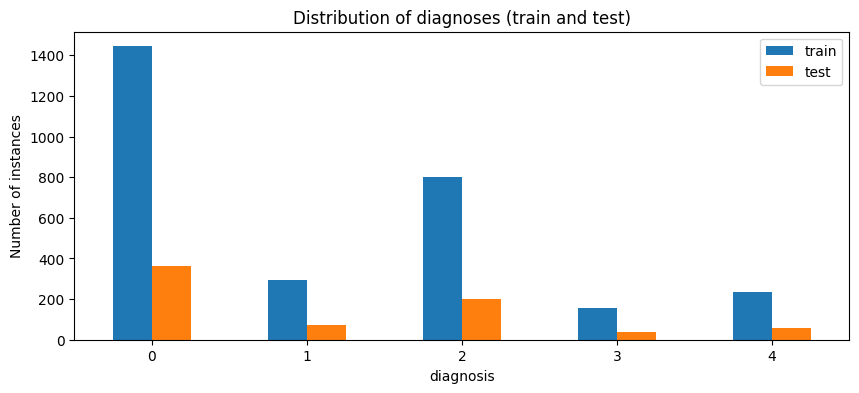

In [5]:
# y distribution
y_dist_train = train_labels_df['diagnosis'].value_counts().sort_index()
y_dist_test = test_labels_df['diagnosis'].value_counts().sort_index()
print('y distribution (train):', y_dist_train)
print('y distribution (test):', y_dist_test)

# plot distributions
combined_y_dist = pd.DataFrame({'train': y_dist_train, 'test': y_dist_test})
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
combined_y_dist.plot(kind='bar', stacked=False, ax=ax, title='Distribution of diagnoses (train and test)', rot=0)
ax.set_ylabel('Number of instances')
plt.show()

In [6]:
from tensorflow import keras

# Global Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
PATIENCE = 8
SEEDS = [564258, 564307, 564322]
NUM_CLASSES = 5

In [7]:
model = keras.models.load_model('b3-head-564258.keras')

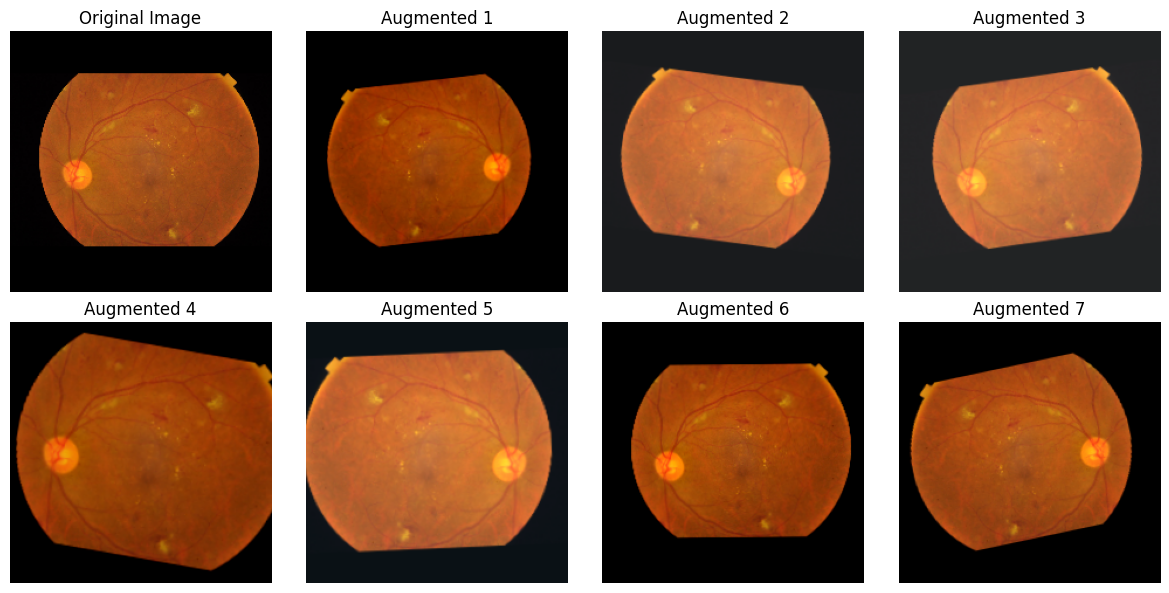

In [43]:
# Preprocessing & Augmentation
def get_data_augmentation():
    return keras.models.Sequential([
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.05),
        keras.layers.RandomZoom(height_factor=(-0.2, 0.1)),
        keras.layers.RandomBrightness(factor=0.15),
        keras.layers.RandomContrast(factor=0.15)
    ], name="data_augmentation")

data_augmentation = get_data_augmentation()

# Define a function to load and preprocess a single image for visualization
def load_and_preprocess_image(path, label=None):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)
    # No normalization here, keep original pixel values for display
    return img, label

test_image_paths = test_labels_df.index.map(lambda id: f'{IMAGESDIR}/{id}.png').values
test_labels = test_labels_df['diagnosis'].values

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_image_paths, test_labels))
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, lbl: (data_augmentation(img, training=True), lbl))
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Get a random image path from the training set
rng = np.random.default_rng(seed=SEEDS[0])
random_index = rng.integers(0, len(test_labels_df) - 1)
random_image_id = test_labels_df.index[random_index]
random_image_path = f"{IMAGESDIR}/{random_image_id}.png"

# Load and preprocess the original image
original_image, _ = load_and_preprocess_image(random_image_path)

# Create a figure to display the images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

# Display the original image
axes[0].imshow(original_image.numpy().astype("uint8"))
axes[0].set_title("Original Image")
axes[0].axis("off")

# Display augmented images
for i in range(1, 8):
    augmented_image = data_augmentation(original_image, training=True)
    # Remove the batch dimension and convert to uint8 for display
    axes[i].imshow(augmented_image.numpy().astype("uint8"))
    axes[i].set_title(f"Augmented {i}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

Preparing base test dataset with RAW images...
Classifying original test images (feeding raw images to model)...
23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step
Generating and classifying 10 augmented images per test image...


100%|██████████| 733/733 [16:10<00:00,  1.32s/it]


Visualizing the counts of identical classifications...


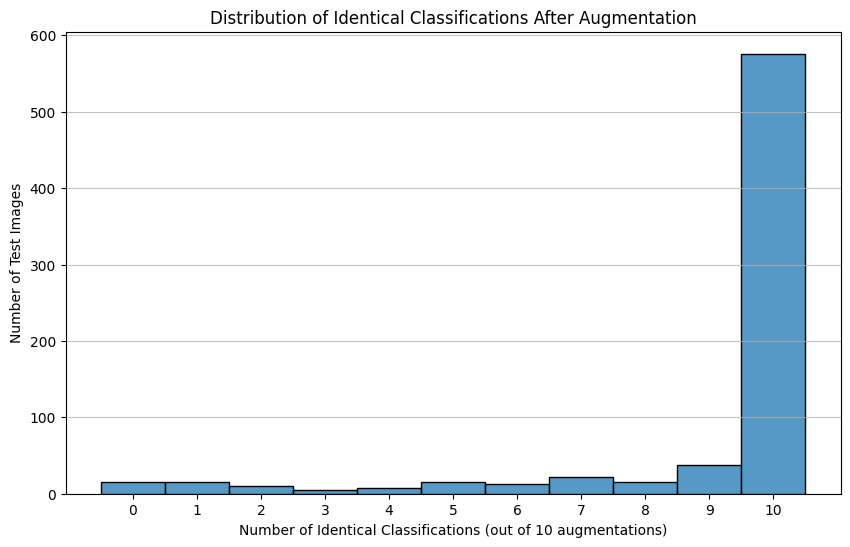

Experiment complete.


In [44]:
def run_experiment(model, test_labels_df, data_augmentation, num_augmentations=10):
    print("Preparing base test dataset with RAW images...")
    test_image_paths = test_labels_df.index.map(lambda id: f'{IMAGESDIR}/{id}.png').values

    # Create dataset of RAW image tensors [0, 255]
    base_test_ds = (
        tf.data.Dataset.from_tensor_slices(test_image_paths)
        .map(lambda path: tf.io.read_file(path), num_parallel_calls=tf.data.AUTOTUNE)
        .map(lambda x: tf.image.decode_jpeg(x, channels=3), num_parallel_calls=tf.data.AUTOTUNE)
        .map(lambda x: tf.image.resize_with_pad(x, IMG_SIZE, IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE)
    )

    print("Classifying original test images (feeding raw images to model)...")
    original_predictions = model.predict(base_test_ds.batch(BATCH_SIZE))
    original_predicted_classes = np.argmax(original_predictions, axis=1)

    print(f"Generating and classifying {num_augmentations} augmented images per test image...")
    identical_classification_counts = []

    # Iterate over raw images and their correct original predictions
    for original_image, original_pred_class in tqdm(zip(base_test_ds, original_predicted_classes), total=len(test_labels_df)):
        identical_count = 0
        for _ in range(num_augmentations):
            # Augmentation is done on the raw [0, 255] image
            augmented_image = data_augmentation(original_image, training=True)
            # add a batch dimension
            augmented_image_batched = tf.expand_dims(augmented_image, 0)
            # Classify the augmented image
            augmented_pred = np.argmax(model.predict(augmented_image_batched, verbose=0), axis=1)[0]

            if augmented_pred == original_pred_class:
                identical_count += 1

        identical_classification_counts.append(identical_count)

    print("Visualizing the counts of identical classifications...")
    plt.figure(figsize=(10, 6))
    sns.histplot(identical_classification_counts, bins=range(num_augmentations + 2), kde=False, discrete=True)
    plt.title('Distribution of Identical Classifications After Augmentation')
    plt.xlabel(f'Number of Identical Classifications (out of {num_augmentations} augmentations)')
    plt.ylabel('Number of Test Images')
    plt.xticks(range(num_augmentations + 1))
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    print("Experiment complete.")
    return identical_classification_counts

identical_counts = run_experiment(model, test_labels_df, data_augmentation, num_augmentations=10)

Preparing base test dataset with RAW images...
Classifying original test images (feeding raw images to model)...
23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step
Generating and classifying 10 augmented images per test image...


100%|██████████| 733/733 [16:22<00:00,  1.34s/it]


Visualizing the counts of identical classifications by true label...


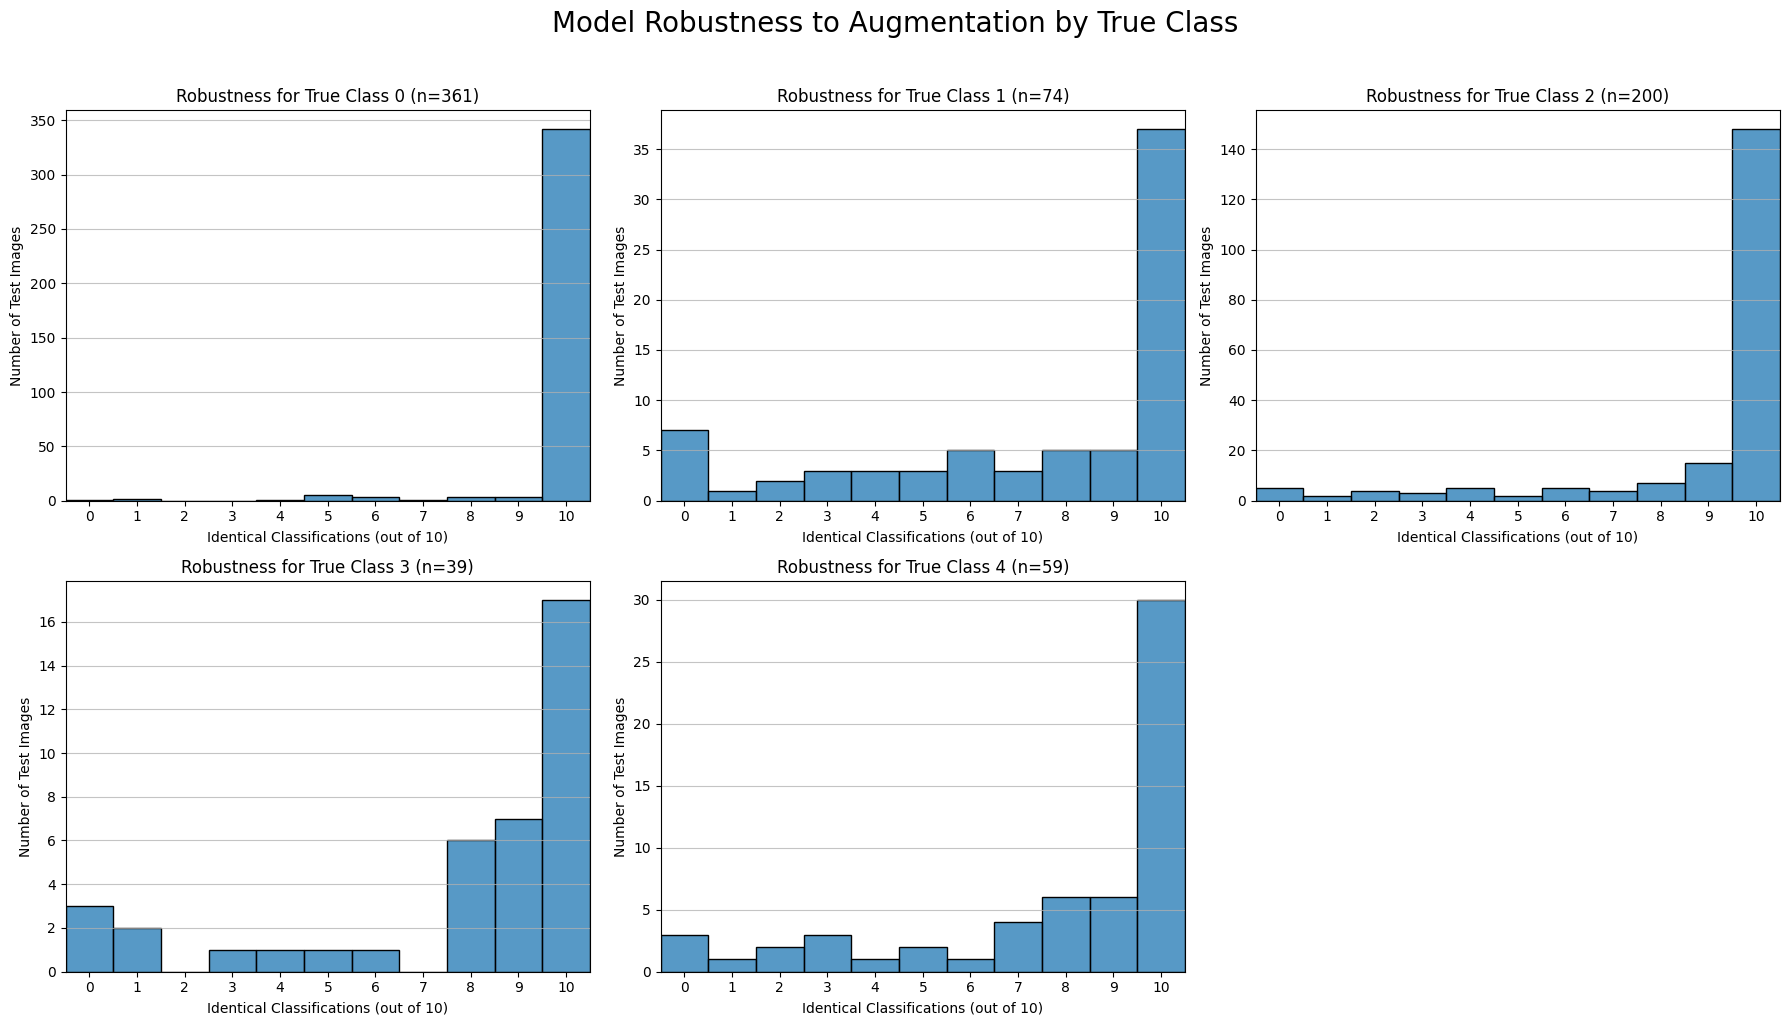

Experiment complete.

Raw counts dictionary:
Class 0: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 5, 6, 10, 10]...
Class 1: [10, 10, 10, 6, 3, 10, 8, 10, 8, 10, 10, 3, 10, 10, 10, 3, 2, 9, 10, 10]...
Class 2: [2, 10, 10, 9, 10, 10, 6, 10, 8, 10, 10, 0, 10, 0, 10, 10, 10, 10, 10, 10]...
Class 3: [10, 0, 10, 9, 8, 10, 10, 6, 10, 8, 0, 9, 9, 10, 9, 1, 0, 10, 3, 10]...
Class 4: [9, 10, 5, 10, 10, 9, 9, 10, 10, 7, 10, 7, 7, 8, 8, 8, 10, 8, 6, 10]...


In [ ]:
def run_experiment_by_class(model, test_labels_df, data_augmentation, num_augmentations=10):
    """
    Runs the robustness experiment and generates separate histograms of identical
    classification counts for each true class label.
    """
    print("Preparing base test dataset with RAW images...")
    test_image_paths = test_labels_df.index.map(lambda id: f'{IMAGESDIR}/{id}.png').values
    test_labels = test_labels_df['diagnosis'].values

    # Create dataset of RAW image tensors [0, 255]
    base_test_ds = (
        tf.data.Dataset.from_tensor_slices(test_image_paths)
        .map(lambda path: tf.io.read_file(path), num_parallel_calls=tf.data.AUTOTUNE)
        .map(lambda x: tf.image.decode_jpeg(x, channels=3), num_parallel_calls=tf.data.AUTOTUNE)
        .map(lambda x: tf.image.resize_with_pad(x, IMG_SIZE, IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE)
    )

    print("Classifying original test images (feeding raw images to model)...")
    original_predictions = model.predict(base_test_ds.batch(BATCH_SIZE))
    original_predicted_classes = np.argmax(original_predictions, axis=1)

    # Initialize a dictionary to store results for each class
    num_classes = len(test_labels_df['diagnosis'].unique())
    class_counts = {i: [] for i in range(num_classes)}

    print(f"Generating and classifying {num_augmentations} augmented images per test image...")
    # Iterate over images, their original predictions, AND their true labels
    iterator = zip(base_test_ds, original_predicted_classes, test_labels)
    for original_image, original_pred_class, true_label in tqdm(iterator, total=len(test_labels_df)):
        identical_count = 0
        for _ in range(num_augmentations):
            augmented_image = data_augmentation(original_image, training=True)
            augmented_image_batched = tf.expand_dims(augmented_image, 0)
            augmented_pred = np.argmax(model.predict(augmented_image_batched, verbose=0), axis=1)[0]
            if augmented_pred == original_pred_class:
                identical_count += 1

        class_counts[true_label].append(identical_count)

    print("Visualizing the counts of identical classifications by true label...")
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten() # Flatten the 2x3 grid into a 1D array for easy iteration

    for i in range(num_classes):
        ax = axes[i]
        counts_for_class = class_counts[i]

        if not counts_for_class:
            ax.text(0.5, 0.5, 'No test images for this class', ha='center', va='center')
            ax.set_title(f'Class {i} (No Data)')
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        sns.histplot(data=counts_for_class, bins=range(num_augmentations + 2), kde=False, discrete=True, ax=ax)
        ax.set_title(f'Robustness for True Class {i} (n={len(counts_for_class)})')
        ax.set_xlabel(f'Identical Classifications (out of {num_augmentations})')
        ax.set_ylabel('Number of Test Images')
        ax.set_xticks(range(num_augmentations + 1))
        ax.grid(axis='y', alpha=0.75)
        ax.set_xlim(-0.5, num_augmentations + 0.5)

    # Hide the last unused subplot if num_classes is not a multiple of 3
    if num_classes < len(axes):
        for j in range(num_classes, len(axes)):
            fig.delaxes(axes[j])

    fig.suptitle('Model Robustness to Augmentation by True Class', fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

    print("Experiment complete.")
    return class_counts


class_specific_counts = run_experiment_by_class(model, test_labels_df, data_augmentation, num_augmentations=10)

print("\nRaw counts dictionary:")
for class_label, counts in class_specific_counts.items():
    print(f"Class {class_label}: {counts[:20]}...")